<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/lead_scoirngAutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 24th May, 2021
# My folder: C:\Users\ashok\OneDrive\Documents\leads_scoring
#
# AutoML:
# Ref: https://evalml.alteryx.com/en/stable/demos/lead_scoring.html
# Lead scoring:
#      https://towardsdatascience.com/a-true-end-to-end-ml-example-lead-scoring-f5b52e9a3c80
# Kaggle 
#      https://www.kaggle.com/ashydv/leads-dataset

# Building a Lead Scoring Model with EvalML

In this example, we will build an optimized lead scoring model using EvalML. To optimize the pipeline, we will set up an objective function to maximize the revenue generated with true positives while taking into account the cost of false positives. At the end of this demo, we also show you how introducing the right objective during the training is significantly better than using a generic machine learning metric like AUC.

## Install packages

EvalML is an AutoML library that builds, optimizes, and evaluates machine learning pipelines using domain-specific objective functions.

Combined with Featuretools and Compose, EvalML can be used to create end-to-end supervised machine learning solutions.

In [1]:
# Install evalml. Some of the packages installed are:
# imbalanced-learn, scikit-optimize, plotly, category-encoders,
# graphviz, lightgbm, shap, statsmodels, catboost, scikit-learn
# featuretools, matplotlib,nltk,xgboost, pmdarima (for the anagram of 'py' + 'arima')
# kaleido (blockchain) 

!pip install evalml
! pip install dask[dataframe] --upgrade 

     |████████████████████████████████| 6.2MB 2.8MB/s 
     |████████████████████████████████| 5.7MB 16.5MB/s 
     |████████████████████████████████| 215kB 36.6MB/s 
     |████████████████████████████████| 67.3MB 55kB/s 
     |████████████████████████████████| 10.3MB 28.5MB/s 
     |████████████████████████████████| 15.3MB 240kB/s 
     |████████████████████████████████| 307kB 35.9MB/s 
     |████████████████████████████████| 148.9MB 88kB/s 
     |████████████████████████████████| 13.2MB 28.5MB/s 
     |████████████████████████████████| 6.7MB 22.5MB/s 
     |████████████████████████████████| 1.8MB 26.2MB/s 
     |████████████████████████████████| 358kB 42.7MB/s 
     |████████████████████████████████| 22.3MB 6.7MB/s 
     |████████████████████████████████| 1.5MB 26.0MB/s 
     |████████████████████████████████| 18.0MB 253kB/s 
     |████████████████████████████████| 79.9MB 117kB/s 
     |████████████████████████████████| 296kB 37.7MB/s 
     |████████████████████████████████| 92kB 9.7

     |████████████████████████████████| 962kB 3.9MB/s 
     |████████████████████████████████| 112kB 8.4MB/s 
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


## Call libraries

In [30]:
# Call libraries
# 1.0 Data manipulation
import numpy as np
import pandas as pd

# 1.1 Auto Machine Learning
# conda install -c conda-forge evalml
import evalml
from evalml import AutoMLSearch
from evalml.objectives import LeadScoring

# 1.2 URL open
from urllib.request import urlopen

# 1.3 Woodwork makes it easy to manage additional
#      'data-typing' information for your data,
#        and, therefore, access only the data one needs
#         based on these additional data-types, called
#          logical types or semantic tags.
#           It is used by featuretools and evalml

import woodwork as ww

# 1.4 Misc
import time

In [31]:
# 1.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Dataset

We will be utilizing a dataset detailing a customer’s job, country, state, zip, online action, the dollar amount of that action and whether they were a successful lead.

In [6]:
# Open URLs to access data
customers_data      = urlopen('https://featurelabs-static.s3.amazonaws.com/lead_scoring_ml_apps/customers.csv')
interactions_data   = urlopen('https://featurelabs-static.s3.amazonaws.com/lead_scoring_ml_apps/interactions.csv')
leads_data          = urlopen('https://featurelabs-static.s3.amazonaws.com/lead_scoring_ml_apps/previous_leads.csv')

# Method read() can be used to read data
##print(customers_data.read())

In [7]:
# Read lead-score tables from opened URL
customers = pd.read_csv(customers_data)
interactions = pd.read_csv(interactions_data)
leads = pd.read_csv(leads_data)

In [8]:
# Look at data
customers.shape    # (1000, 11)
customers.head()

(1000, 11)

,customer_id,date_registered,birthday,job,phone,email,country,state,zip,owner,company
0,460429349361,2017-08-10 11:04:45,NaN,"Engineer, mining",+1-283-990-1507x7713,christian92@gmail.com,NaN,NY,60091.0,Kathleen Hawkins MD,6.185414e+11
1,392559384176,2017-08-10 23:13:51,NaN,Arts administrator,400.808.2148,jenniferdavis@carter-ellis.biz,US,CA,NaN,John Edwards,8.330990e+11
2,674438580580,2017-08-11 08:35:32,NaN,"Psychologist, forensic",(299)543-9962,wwelch@lee.com,US,CA,NaN,John Edwards,2.114827e+11
3,364017777045,2017-08-11 10:15:37,NaN,Air cabin crew,+1-213-455-5314,xjones@smith.net,US,NaN,60091.0,Erica Anderson,NaN
4,551397602202,2017-08-11 13:33:23,NaN,Press sub,619.795.6618,walterromero@gmail.com,US,NaN,NaN,Kathleen Hawkins MD,NaN


In [9]:
#
interactions.shape  # (5625, 7)
interactions.head()

(5625, 7)

,id,time,customer_id,action,amount,session,referrer
0,807870369974,2017-08-17 18:18:45,676332384432,contact_form,NaN,531094009776,https://www.twitter.com
1,889936071815,2017-08-18 18:58:39,676332384432,contact_form,NaN,531094009776,https://www.twitter.com
2,890016715098,2017-08-22 15:54:26,756895858030,purchase,50.54,355429835992,NaN
3,539965059120,2017-08-24 23:25:33,676332384432,page_view,NaN,531094009776,NaN
4,496056352403,2017-08-25 09:32:25,676332384432,page_view,NaN,531094009776,https://medium.com/article


In [10]:
#
leads.shape  # (584, 3)
leads.head()

(584, 3)

,customer_id,time,label
0,961424493033,2017-09-17 08:20:09,False
1,739795366381,2017-09-20 18:14:56,False
2,433081973416,2017-09-26 12:14:42,False
3,178336564320,2017-09-29 12:48:25,False
4,203924762965,2017-10-02 02:57:06,False


In [14]:
customers.to_csv("customers.csv", index = False)
interactions.to_csv("interactions.csv", index = False)
leads.to_csv("leads.csv", index=False)

## Configure LeadScoring objectives

To optimize the pipelines toward the specific business needs of this model, you can set your own assumptions for how much value is gained through true positives and the cost associated with false positives. These parameters are

> true_positive - dollar amount to be gained with a successful lead  
false_positive - dollar amount to be lost with an unsuccessful lead

Using these parameters, EvalML builds a pileline that will maximize the amount of revenue per lead generated.

In [15]:
lead_scoring_objective = LeadScoring(
                                      true_positives=1000,
                                      false_positives=-10
                                    )

In [21]:
# Merge the three datasets
X = customers.merge(
                    interactions,
                    on='customer_id').merge(
                                            leads,
                                            on='customer_id'
                                            )
y = X['label']

In [22]:
X = X.drop(
            [ 'customer_id', 'date_registered', 'birthday','phone', 'email',
              'owner', 'company', 'id', 'time_x',
              'session', 'referrer', 'time_y', 'label', 'country'],
              axis=1
           )

display(X.head())

,job,state,zip,action,amount
0,"Engineer, mining",NY,60091.0,page_view,NaN
1,"Psychologist, forensic",CA,NaN,purchase,135.23
2,"Psychologist, forensic",CA,NaN,page_view,NaN
3,Air cabin crew,NaN,60091.0,download,NaN
4,Air cabin crew,NaN,60091.0,page_view,NaN


In [25]:
# Transform X and y to Woodwork Dataframes
# and look at logical type and semantic tags
X1 = ww.DataTable(X)    # Pandas DataFrame to DataTable
y1 =  ww.DataColumn(y)  # Pandas Series to DataColumn

#
X1.types

#
print()
type(X1)
print()
type(y1)

,Physical Type,Logical Type,Semantic Tag(s)
Data Column,,,
job,string,NaturalLanguage,[]
state,category,Categorical,['category']
zip,float64,Double,['numeric']
action,category,Categorical,['category']
amount,float64,Double,['numeric']


woodwork.datatable.DataTable

woodwork.datacolumn.DataColumn

In [26]:
# As 'job' column does not get any type,
# we explicitly add one:

X = ww.DataTable(X, semantic_tags={'job': 'category'}, logical_types={'job': 'Categorical'})
y = ww.DataColumn(y)
X.types

,Physical Type,Logical Type,Semantic Tag(s)
Data Column,,,
job,category,Categorical,['category']
state,category,Categorical,['category']
zip,float64,Double,['numeric']
action,category,Categorical,['category']
amount,float64,Double,['numeric']


## Search for the best pipeline¶

In order to validate the results of the pipeline creation and optimization process, we will save some of our data as a holdout set.

EvalML natively supports one-hot encoding and imputation so the above NaN and categorical values will be taken care of.

In [27]:
X_train, X_holdout, y_train, y_holdout = evalml. \
                                         preprocessing. \
                                         split_data(
                                                     X, y,
                                                     problem_type='binary',
                                                     test_size=0.2,
                                                     random_seed=0
                                                    )
print(X.types)

            Physical Type Logical Type Semantic Tag(s)
Data Column                                           
job              category  Categorical    ['category']
state            category  Categorical    ['category']
zip               float64       Double     ['numeric']
action           category  Categorical    ['category']
amount            float64       Double     ['numeric']


Because the lead scoring labels are binary, we will use `AutoMLSearch(X_train=X_train, y_train=y_train, problem_type='binary')`. When we call `.search()`, the search for the best pipeline will begin.

In [32]:
# Instantiate AutoMLSearch class 
automl = AutoMLSearch(
                      X_train=X_train,
                      y_train=y_train,
                      problem_type='binary',
                      objective=lead_scoring_objective,
                      additional_objectives=['auc'],
                      max_batches=3,
                      optimize_thresholds=True,
                      sampler_method=None)



Generating pipelines to search over...
8 pipelines ready for search.


In [33]:
start = time.time()
automl.search()
end = time.time()
print("Time taken: ", (end-start)/60)


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Lead Scoring. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 3 batches for a total of 19 pipelines. 
Allowed model families: extra_trees, linear_model, xgboost, random_forest, lightgbm, decision_tree, catboost



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: 0.000

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Classifier w/ Imputer + One Hot Encoder + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: 15.550
Decision Tree Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: 14.821
Random Forest Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: 14.515
LightGBM Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: 13.354
Logistic Regression Classifier w/ Imputer + One Hot Encoder + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Lead Sc

## View rankings and select pipeline

Once the fitting process is done, we can see all of the pipelines that were searched, ranked by their score on the lead scoring objective we defined.

In [34]:
automl.rankings

,id,pipeline_name,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,18,Elastic Net Classifier w/ Imputer + One Hot En...,15.996914,0.645669,16.741935,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,8,CatBoost Classifier w/ Imputer,15.996914,0.645669,16.741935,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,7,Extra Trees Classifier w/ Imputer + One Hot En...,15.293603,0.436765,14.877419,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
9,5,Logistic Regression Classifier w/ Imputer + On...,14.940900,0.914874,13.929032,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
10,2,Decision Tree Classifier w/ Imputer + One Hot ...,14.820570,2.443147,16.741935,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
11,6,XGBoost Classifier w/ Imputer + One Hot Encoder,14.536504,1.124271,15.541935,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
12,3,Random Forest Classifier w/ Imputer + One Hot ...,14.514975,0.504420,14.948387,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
15,4,LightGBM Classifier w/ Imputer + One Hot Encoder,13.353574,1.575213,14.400000,inf,False,{'Imputer': {'categorical_impute_strategy': 'm...
18,0,Mode Baseline Binary Classification Pipeline,0.000000,0.000000,0.000000,0.0,False,{'Baseline Classifier': {'strategy': 'mode'}}


To select the best pipeline we can call automl.best_pipeline.

In [35]:
best_pipeline = automl.best_pipeline

You can get more details about any pipeline, including how it performed on other objective functions by calling `.describe_pipeline()` and specifying the id of the pipeline.

In [36]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


*************************************************************************
* Elastic Net Classifier w/ Imputer + One Hot Encoder + Standard Scaler *
*************************************************************************

Problem Type: binary
Model Family: Linear

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : median
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * features_to_encode : None
	 * categories : None
	 * drop : if_binary
	 * handle_unknown : ignore
	 * handle_missing : error
3. Standard Scaler
4. Elastic Net Classifier
	 * alpha : 0.29753460654447234
	 * l1_ratio : 0.056712977317443194
	 * n_jobs : -1
	 * max_iter : 1000
	 * penalty : elasticnet
	 * loss : log

Training
Training for binary problems.
Objective to optimize binary classification pipeline thresholds for: <evalml.objectives.lead_scoring.LeadScoring object at 0x7f439b8a7510>
Total training time (includi

## Evaluate on hold out

Finally, since the best pipeline was trained on all of the training data, we evaluate it on the holdout dataset.

In [37]:
best_pipeline.score(X_holdout, y_holdout, objectives=["auc", lead_scoring_objective])

OrderedDict([('AUC', 0.5098670293139922),
             ('Lead Scoring', 15.382631126397248)])

## Why optimize for a problem-specific objective?

To demonstrate the importance of optimizing for the right objective, let’s search for another pipeline using AUC, a common machine learning metric. After that, we will score the holdout data using the lead scoring objective to see how the best pipelines compare.

In [40]:
# Instantiate AutoMLSearch class
automl_auc = evalml.AutoMLSearch(
                                 X_train=X_train,
                                 y_train=y_train,
                                 problem_type='binary',
                                 objective='auc',
                                 additional_objectives=[],
                                 max_batches=3,
                                 optimize_thresholds=True,
                                 sampler_method=None)

# Execute search()
automl_auc.search()

Generating pipelines to search over...
8 pipelines ready for search.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for AUC. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 3 batches for a total of 19 pipelines. 
Allowed model families: extra_trees, linear_model, xgboost, random_forest, lightgbm, decision_tree, catboost



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean AUC: 0.500

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Classifier w/ Imputer + One Hot Encoder + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean AUC: 0.630
Decision Tree Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean AUC: 0.594
Random Forest Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean AUC: 0.682
LightGBM Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean AUC: 0.671
Logistic Regression Classifier w/ Imputer + One Hot Encoder + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean AUC: 0.681
XGBoost Classifier w/ Imputer + One Hot Encod

In [42]:
automl_auc.rankings

,id,pipeline_name,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,6,XGBoost Classifier w/ Imputer + One Hot Encoder,0.701032,0.024980,0.720642,20.103249,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,7,Extra Trees Classifier w/ Imputer + One Hot En...,0.689375,0.036617,0.727598,18.937464,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,3,Random Forest Classifier w/ Imputer + One Hot ...,0.682025,0.050716,0.732789,18.202538,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,5,Logistic Regression Classifier w/ Imputer + On...,0.680753,0.013682,0.696548,18.075341,False,{'Imputer': {'categorical_impute_strategy': 'm...
10,4,LightGBM Classifier w/ Imputer + One Hot Encoder,0.671060,0.028763,0.698287,17.105985,False,{'Imputer': {'categorical_impute_strategy': 'm...
14,1,Elastic Net Classifier w/ Imputer + One Hot En...,0.630335,0.003036,0.626837,13.033470,False,{'Imputer': {'categorical_impute_strategy': 'm...
16,2,Decision Tree Classifier w/ Imputer + One Hot ...,0.594215,0.006959,0.601705,9.421468,False,{'Imputer': {'categorical_impute_strategy': 'm...
17,8,CatBoost Classifier w/ Imputer,0.542394,0.039310,0.505055,4.239420,False,{'Imputer': {'categorical_impute_strategy': 'm...
18,0,Mode Baseline Binary Classification Pipeline,0.500000,0.000000,0.500000,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}


Like before, we can look at the rankings and pick the best pipeline.

In [43]:
best_pipeline_auc = automl_auc.best_pipeline

In [44]:
# get the auc and lead scoring score on holdout data
best_pipeline_auc.score(
                        X_holdout,
                        y_holdout,
                        objectives=[
                                     "auc",
                                     lead_scoring_objective
                                    ]
                        )

OrderedDict([('AUC', 0.6687518887881535), ('Lead Scoring', 0.0)])

When we optimize for AUC, we can see that the AUC score from this pipeline is better than the AUC score from the pipeline optimized for lead scoring. However, the revenue per lead is much smaller per lead when optimized for AUC and was much larger when optimized for lead scoring. As a result, we would have a huge gain on the amount of revenue if we optimized for lead scoring.

This happens because optimizing for AUC does not take into account the user-specified true_positive (dollar amount to be gained with a successful lead) and false_positive (dollar amount to be lost with an unsuccessful lead) values. Thus, the best pipelines may produce the highest AUC but may not actually generate the most revenue through lead scoring.

This example highlights how performance in the real world can diverge greatly from machine learning metrics.

In [45]:
best_pipeline_auc.graph_feature_importance()

In [47]:
best_pipeline_auc.input_feature_names

{'Imputer': ['job', 'state', 'zip', 'action', 'amount'],
 'One Hot Encoder': ['job', 'state', 'zip', 'action', 'amount'],
 'XGBoost Classifier': ['zip',
  'amount',
  'job_Bookseller',
  'job_Chartered management accountant',
  'job_Clothing/textile technologist',
  'job_Development worker, community',
  'job_Insurance claims handler',
  'job_Medical illustrator',
  'job_Naval architect',
  'job_Scientist, biomedical',
  'job_Scientist, forensic',
  'job_Television/film/video producer',
  'state_CA',
  'state_FL',
  'state_IL',
  'state_MA',
  'state_NY',
  'action_contact_form',
  'action_download',
  'action_page_view',
  'action_purchase']}

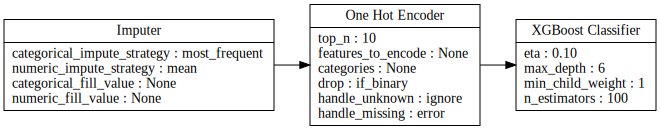

In [56]:
#visualizing best pipeline flow 
best_pipeline_auc.graph()

In [48]:
from evalml.model_understanding import graph_roc_curve

In [51]:
best_pipeline.save("model.pkl")

In [52]:
check_model=automl.load('model.pkl')

In [54]:
check_model.predict_proba(X_holdout).to_dataframe()

,False,True
0,0.950313,0.049687
1,0.950313,0.049687
2,0.950313,0.049687
3,0.950313,0.049687
4,0.950313,0.049687
...,...,...
1158,0.950313,0.049687
1159,0.950313,0.049687
1160,0.950313,0.049687
1161,0.950313,0.049687


In [59]:
from evalml.model_understanding.graphs import graph_confusion_matrix, graph_roc_curve

# pipeline trained with log loss
y_pred = best_pipeline_auc.predict(X_holdout)
graph_confusion_matrix(y_holdout, y_pred)



In [62]:
y_pred = best_pipeline_auc.predict_proba(X_holdout)
graph_roc_curve(y_holdout, y_pred)

In [ ]:
########## I am done ##############